In [1]:
# section 1 load all the necessary modules and packages
import glob
import time
import netCDF4 as nc4
import numpy as np
import pandas as pd
import xarray as xr
# not neccessary for the function but for visualziation
import matplotlib.pyplot as plt
import warnings
import sys
import os
import platform
import shutil


In [12]:
###########################
# replacing string function
###########################
def replace_string(file_in, file_out, replacement_dict):
    """
    Replace strings in a text file using a dictionary of replacements and save the modified content to a new file.

    Parameters:
        file_in (str): Path to the input text file.
        file_out (str): Path to the output text file.
        replacement_dict (dict): Dictionary of old strings as keys and their corresponding replacements as values.

    Returns:
        None
    """
    try:
        with open(file_in, "r+") as text_file:
            texts = text_file.read()
            for old_str, new_str in replacement_dict.items():
                texts = texts.replace(old_str, new_str)

        with open(file_out, "w") as text_file:
            text_file.write(texts)

        print("Strings replaced and saved successfully!")

    except Exception as e:
        print(f"An error occurred: {e}")
        
import xarray as xr

def replace_and_save_netcdf(input_file, output_file, variable_values):
    """
    Reads the input NetCDF file, replaces the specified variables with new values,
    and saves the modified data as a new NetCDF file.

    Parameters:
        input_file (str): Path to the input NetCDF file.
        output_file (str): Name of the output NetCDF file.
        variable_values (dict): Dictionary of variable names and their corresponding new values.

    Returns:
        None
    """
    try:
        # Read the input NetCDF file using xarray
        ds = xr.open_dataset(input_file)

        # Replace variables with new values
        for var_name, new_value in variable_values.items():
            if var_name in ds:
                ds[var_name].values[:] = new_value

        # Save the modified data to the output NetCDF file
        if os.path.isfile(output_file):
            os.remove(output_file)
        ds.to_netcdf(output_file)

        # Close the dataset
        ds.close()

        print(f"Data with modified variables saved to {output_file}")

    except Exception as e:
        print(f"Error: {e}")


def copy_folderA_to_folderB(path_org, path_target):
    """
    Copy the contents of folder A into folder B and remove any files or folders in folder B
    that are not present in folder A.

    Parameters:
        path_org (str): Path to the source folder A.
        path_target (str): Path to the target folder B.

    Returns:
        None
    """
    try:
        # Check if the target folder B exists; if not, copy the entire folder A to B
        if not os.path.isdir(path_target):
            shutil.copytree(path_org, path_target)
        else:
            # Remove any files or folders in folder B that are not present in folder A
            for root, dirs, files in os.walk(path_target):
                for name in files + dirs:
                    path = os.path.join(root, name)
                    if not os.path.exists(os.path.join(path_org, os.path.relpath(path, path_target))):
                        os.remove(path)

        print("Folder A contents copied to folder B with cleanup.")
    except Exception as e:
        print(f"An error occurred: {e}")
        

def gen_param(param_lim_low, param_lim_up, n):
    """
    Generate random parameter values within specified lower and upper limits.

    Parameters:
        param_lim_low (numpy.ndarray): 1D array of lower limits for each parameter.
        param_lim_up (numpy.ndarray): 1D array of upper limits for each parameter.
        n (int): Number of sets of random parameter values to generate.

    Returns:
        numpy.ndarray: A 2D array containing n sets of random parameter values, where each set is a row.

    Raises:
        ValueError: If param_lim_low and param_lim_up have different sizes or if any element in param_lim_low
                    is greater than the corresponding element in param_lim_up.
    """
    if len(param_lim_low) != len(param_lim_up):
        raise ValueError("param_lim_low and param_lim_up must have the same size.")

    if np.any(param_lim_low > param_lim_up):
        raise ValueError("Each element in param_lim_low must be less than or equal to the corresponding element in param_lim_up.")

    # Convert 1D arrays to 2D arrays of shape (n, num_parameters)
    param_lim_low_2D = np.atleast_2d(param_lim_low.flatten()).repeat(repeats=n, axis=0)
    param_lim_up_2D = np.atleast_2d(param_lim_up.flatten()).repeat(repeats=n, axis=0)

    # Generate random numbers between 0 and 1 for each parameter
    random = np.random.rand(n, len(param_lim_low.flatten()))

    # Scale and shift the random numbers to be within the specified parameter limits
    params = param_lim_low_2D + (param_lim_up_2D - param_lim_low_2D) * random

    return params


def slice_simulation(path, variables_to_keep, var_ID, target_IDs):
    
    for file_name in sorted(glob.glob(path)):

        # open netcdf file
        ds = xr.open_dataset(file_name)

        # Drop all variables except the ones to keep with dimension of seg, time, or seg and time
        variables_to_keep = ['IRFroutedRunoff', 'IRFvolume', 'time', 'reachID', 'time_bounds']
        ds = ds.drop_vars([var for var in ds.variables if var not in variables_to_keep])
        
        # get the location of lake victoria and its outflow and slice
        idx = np.where(np.isin(ds[var_ID].values, target_IDs))[0]
        ds = ds.isel(seg = idx)

        # save the file over the original file
        os.remove(file_name)
        ds.to_netcdf(file_name)
    
    



In [15]:
# calibration of the parameters

# generate the random parameters
param_lim_low = np.array([1.00,  50.00, 0.60, 0.60])
param_lim_up  = np.array([3.00, 200.00, 1.40, 1.40])
param_num     = 10

params = gen_param(param_lim_low, param_lim_up, param_num)

# remove and create mizuRoute output folder
shutil.rmtree('../mizuRoute_output_all/')
os.makedirs('../mizuRoute_output_all/')

# copy the set up to a new location
copy_folderA_to_folderB('../mizuRoute/',\
                        '../mizuRoute_sim/')
os.chdir('../mizuRoute_sim/')
os.system('chmod +x route_runoff.exe')

#
for row in params:
    
    # replace the values in the network topology for the HYPE formulation
    variable_values = {'HYP_Erate_emr':row[0],'HYP_Qrate_emr':row[1]}
    replace_and_save_netcdf('./ancillary_data/Network_topology_lake_victoria.nc',\
                            './ancillary_data/Network_topology_lake_victoria.nc',\
                            variable_values)
    
    # prepare the control files based on the replacemenet
    replacement_dict = {'scale_factor_Ep_temp':str("{:.3f}".format(row[2])),\
                        'scale_factor_P_temp':str("{:.3f}".format(row[3]))}
    replace_string('./settings/lake_victoria_temp.control',\
                   './settings/lake_victoria.control',\
                   replacement_dict)
    
    # execute the simulation
    os.system('rm ./output/*') # make sure output folder is empty
    os.system('srun ./route_runoff.exe ./settings/lake_victoria.control') # simulate mizuRoute
    os.system('mv ./output/case_sim.r.2014-01-01-00000.nc ./output/case_sim.r.1979-01-01-00000.nc') # rename restart file
    replace_string('./settings/lake_victoria.control',\
                   './settings/lake_victoria.control',\
                   {'!<fname_state_in>':'<fname_state_in> '})
    os.system('srun ./route_runoff.exe ./settings/lake_victoria.control')
    
    
    # keep only two features from simulation, lake victoria and its outlet and save
    slice_simulation('./output/*.h.*.nc',\
                     ['IRFroutedRunoff', 'IRFvolume', 'time', 'reachID', 'time_bounds'],\
                     'reachID',\
                     [2062605, 7000016]):
    os.system('module load cdo; cdo mergetime ./output/*.h.*.nc ./output/sim_'+str(m).zfill(5)+'.nc')
    os.system('mv ./output/sim_'+str(m).zfill(5)+'.nc '+'../mizuRoute_output_all/'+'sim_'+str(m).zfill(5)+'.nc')
    
    

[ 1.46016767 94.05772668  0.82982816  0.71239496]
[  1.68233548 116.05334171   0.86536478   1.25320553]
[  2.81609241 117.71828736   0.75339126   1.10322288]
[  1.999663   117.48343308   0.86298036   0.91376747]
[  2.10131513 120.26051768   1.12039679   0.7893591 ]
[ 2.99397168 79.22974472  0.72537471  1.32506282]
[  2.70204127 138.64142329   1.19198421   1.09587186]
[  1.39489978 175.61875094   1.03008039   1.1801727 ]
[  1.28073921 109.57796348   0.80321121   0.95745182]
[  1.60729502 159.81466373   0.66815598   0.64600521]
[  2.00859099 192.88667806   1.27568368   0.72614853]
[  1.86439623 191.9124778    0.97330573   0.86488493]
[ 2.77866615 61.7620214   1.25853052  0.98045196]
[  2.53502962 178.54030338   0.81851679   0.71196439]
[ 2.77070469 77.77785337  0.68484025  1.20983214]
[  1.49485181 106.98716162   1.20579258   0.70168397]
[  2.10759503 120.02175544   1.21674499   0.84188484]
[  2.94633383 145.62695583   0.60489795   0.69785496]
[ 2.23201589 87.30700163  1.26258842  0.9737

[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013]
<xarray.Dataset>
Dimensions:  (time: 12784)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2013-12-31
    lon      float64 33.12
    lat      float64 -0.875
Data variables:
    prec     (time) float32 0.582 1.751 3.802 1.043 ... 0.913 4.721 12.09 17.83
    evapw    (time) float32 4.686 4.749 5.318 5.848 ... 6.279 5.527 5.106 5.905
    runoff   (time) float32 3.843 3.76 3.749 3.016 ... 0.9205 0.1361 6.502
Attributes:
    CDI:                        Climate Data Interface version 2.0.5 (https:/...
    Conventions:                CF-1.6
    history:                    Fri Jul 28 23:54:02 2023: cdo sellonlatbox,28...
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    history_of_appended_files:  Mon Jun  8 23:26:42 2020: Appended file runof...
    CDO:   

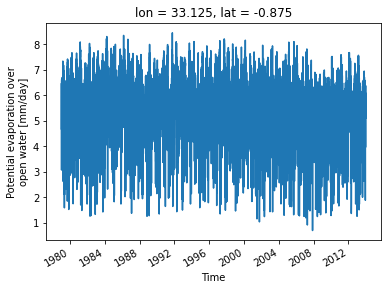

In [21]:
# ###########################
# # get the evaporation for lake victoria 
# ###########################
# file_names = sorted(glob.glob('../mizuRoute/input/mizuRoute_mswep_v1_*_subset.nc'))

# datasets = [xr.open_dataset(file_name) for file_name in file_names]

# merged_dataset = xr.concat(datasets, dim='time')

# # number of years
# time_variable = merged_dataset['time']
# years = time_variable.dt.year
# years = np.array(years)
# n_years = np.unique(years)
# print(n_years)

# merged_dataset_slice = merged_dataset.sel(lat=-1.00, lon=33.00, method='nearest')

# print(merged_dataset_slice)
# merged_dataset_slice['evapw'].plot()

# average_evap = sum(np.array(merged_dataset_slice['evapw'][:]))/len(n_years)

# print(average_evap)

# # get the ratio for scale
# other_evap = np.array([average_evap, 1550, 1350, 1130, 1520, 1450, 1500, 1370, 1590, 1470, 1475, 1590, 1595, 1400])

# # creat the scale factors
# scales = other_evap/average_evap

# # the control to create the restart file
# m = 0
# job_string = ''
# for scale in scales:
    
#     case_name = str(m)
#     scale_value = str("{:.3f}".format(scale))
    
#     replace_string ('../mizuRoute/settings/lake_victoria_temp.control',\
#                     '../mizuRoute/settings/lake_victoria_'+case_name+'.control',\
#                     ['case_temp','scale_factor_temp'],\
#                     ['case_'+case_name+'_'+scale_value,scale_value])
    
#     replace_string ('../mizuRoute/settings/lake_victoria_'+case_name+'.control',\
#                     '../mizuRoute/settings/lake_victoria_'+case_name+'_restart.control',\
#                     ['!<fname_state_in>'],\
#                     ['<fname_state_in> '])
    
#     m +=1
    
#     # add to general string
#     job_string = job_string + '# case'+ case_name +'\n'
#     job_string = job_string + 'srun ./route_runoff.exe ./settings/lake_victoria_'+case_name+'.control \n' +\
#                               'mv ./output/case_'+case_name+'_'+scale_value+'.r.2014-01-01-00000.nc ./output/case_'+case_name+'_'+scale_value+'.r.1979-01-01-00000.nc \n'+\
#                               'srun ./route_runoff.exe ./settings/lake_victoria_'+case_name+'_restart.control \n'
#     job_string = job_string + '\n'
    
    

# shutil.copy('../mizuRoute/lake_victoria_temp.submit', '../mizuRoute/lake_victoria.submit')
# with open('../mizuRoute/lake_victoria.submit', "a") as file:
#     file.write(job_string)
    

In [9]:
import numpy as np

param_lim_low = np.array([1,2,3,4])
param_lim_up = np.array([7,8,9,10])
n =10000

   
param_lim_low_2D = np.atleast_2d(param_lim_low.flatten()).repeat(repeats=n, axis=0)

param_lim_up_2D = np.atleast_2d(param_lim_up.flatten()).repeat(repeats=n, axis=0)

random = np.random.rand(n, len(param_lim_low.flatten()))

params = param_lim_low_2D + (param_lim_up_2D - param_lim_low_2D) * random

print(params)

[[5.37491924 5.81420595 3.7326305  7.47576925]
 [4.96070314 6.1232137  4.20884886 6.6429456 ]
 [3.5917637  2.38478505 4.27414683 4.6085195 ]
 ...
 [3.39774529 4.51012256 8.1367238  9.15243211]
 [1.98997961 7.77399797 5.50727512 5.01730541]
 [2.51483255 5.8196855  3.4979968  8.01001151]]


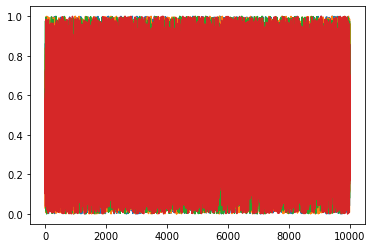

In [10]:
import matplotlib.pyplot as plt

plt.plot(random)